
#### Nome: Caio Martim Barros

#### Matricula: 472713

#Capítulo 2 - Projeto de aprendizado de máquina de ponta a ponta #

**Bem-vindo à Machine Learning Housing Corp.!**

*Sua tarefa é prever os valores médios das casas nos distritos da Califórnia, considerando várias características desses distritos.
Este notebook contém todos os exemplos de código e soluções para os exercícios do capítulo 2.*

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Configuração do Notebook

Primeiro, vamos importar alguns módulos comuns, garantir que o MatplotLib plote as figuras inline e preparar uma função para salvar as figuras. Também verificamos se o Python 3.5 ou posterior está instalado (embora o Python 2.x possa funcionar, ele está obsoleto, portanto, recomendamos fortemente que você use o Python 3), bem como o Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Obter, entender e separar os dados em treino e teste

In [2]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
# Cada linha representa um distrito. Existem 10 atributos

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
# São 20.640 instancias, total_bedrooms tem 207 valores faltantes
# O atributo ocean_proximity é um objeto Python, armazena um campo tipo texto

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
# O dataset possui um atributo categórico
# Veja a sua distribuição

housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
# Resumo dos atributos numéricos, valores nulos são ignorados
# Desvio padrão descreve a dispersão dos dados
# Os percentis indicam o valor abaixo de qual percentual de observações em um grupo de observações cai
# Exemplo: (primeiro quartil) 25% dos distritos tem idade mediana da habitação (housing_median_age) abaixo de 18 anos
#          (mediana) 50% abaixo de 29 anos
#          (terceiro quartil) 75% abaixo de 37 anos

housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


**Para saber mais como interpretar estatísticas descritivas [clique aqui](https://docs.google.com/presentation/d/e/2PACX-1vQK_YzVwcs5X2GLrIz3Ge2obM402udEJmVtF-1WNSvrhD2HwYcOFXggyN6H-ttB-6gL62YiEUcOuYpy/pub?start=false&loop=false&delayms=3000&slide=id.g123902f206d_0_50)**

Saving figure attribute_histogram_plots


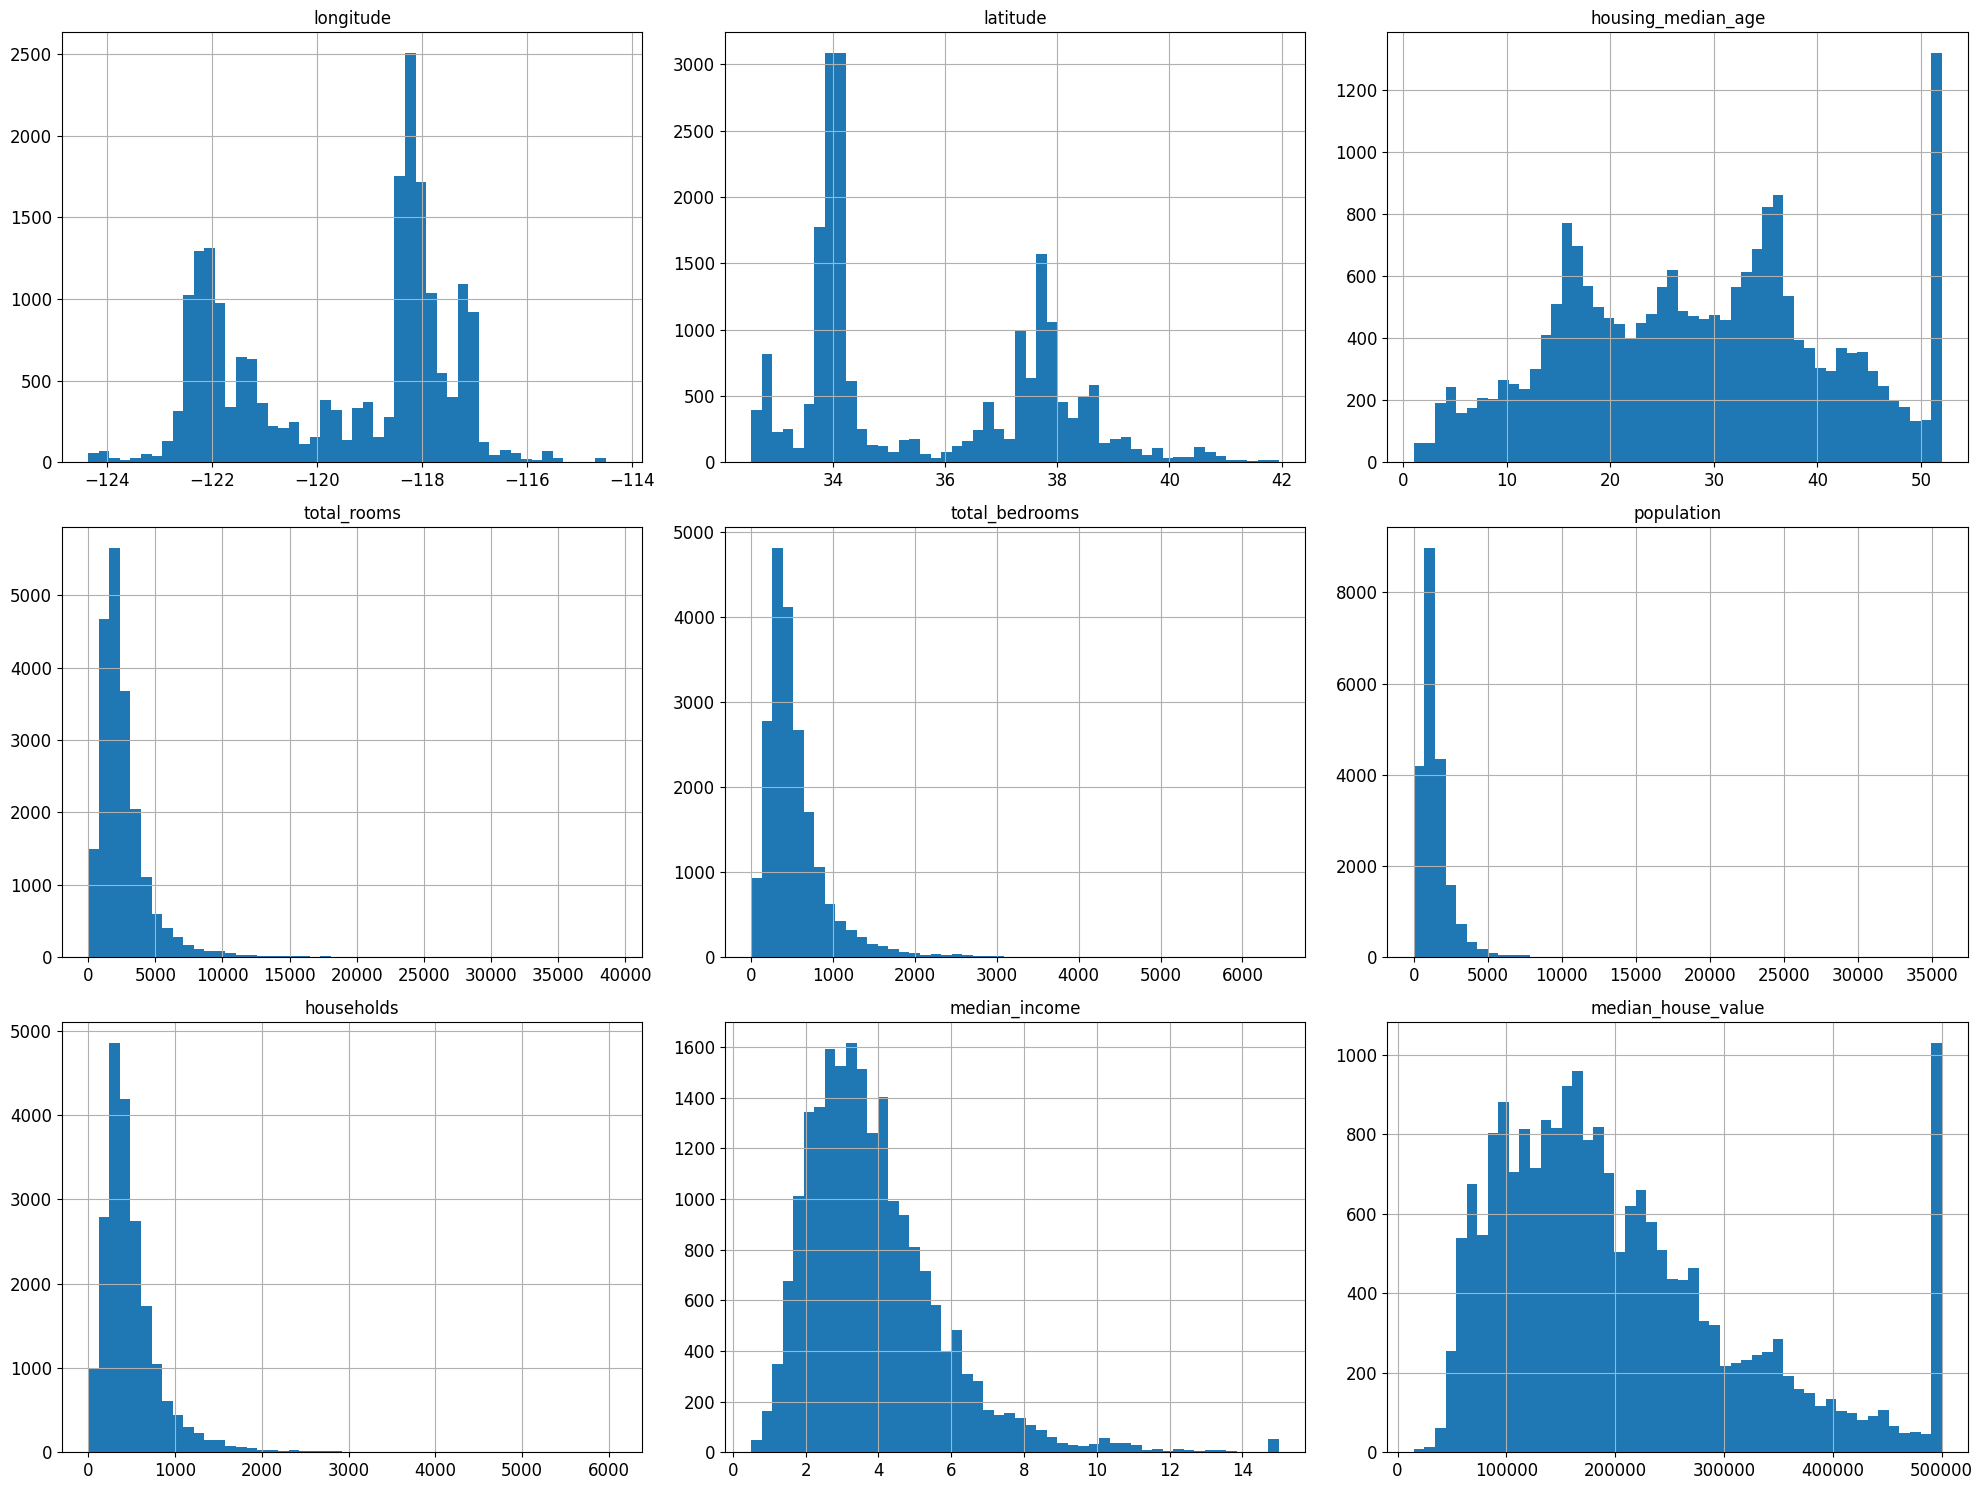

In [8]:
# median_income foi escalado e limitado até 15 (150.000 dolares)
# housing_median_age e median_house_value também foram limitados
# Os atributos possuem diferentes escalas
# Muitos histogramas tem "cauda pesada", isso dificultará alguns algoritmos de ML a detectar padrões

%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [14]:
# O SciKit Learning prove algumas funcoes para dividir os arquivos de treino e teste
# A função mais simples é a train_test_split
# Note que esta função pode usar como parametro o random_state, o qual permite escolher a semente geradora
# Voce pode também passar múltiplos datasets com numeros identicos de linhas e dividi-los pelos mesmos índices 
# Isso é útil se voce tem um dataframe separado para os labels

# CUIDADO ! Se o seu dataset for pequeno, o que é o nosso caso, voce pode ter problemas ao 
# usar métodos de amostragem aleatória, pois pode incluir uma amostra inviesada no seu treinamento. 
# Voce precisa garantir que sua amostragem é estratificada (stratified sampling) 

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

**Para saber mais sobre Amostragem Estratificada [clique aqui](https://docs.google.com/presentation/d/e/2PACX-1vQK_YzVwcs5X2GLrIz3Ge2obM402udEJmVtF-1WNSvrhD2HwYcOFXggyN6H-ttB-6gL62YiEUcOuYpy/pub?start=false&loop=false&delayms=3000&slide=id.g123902f206d_0_7)**

In [15]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


<AxesSubplot:>

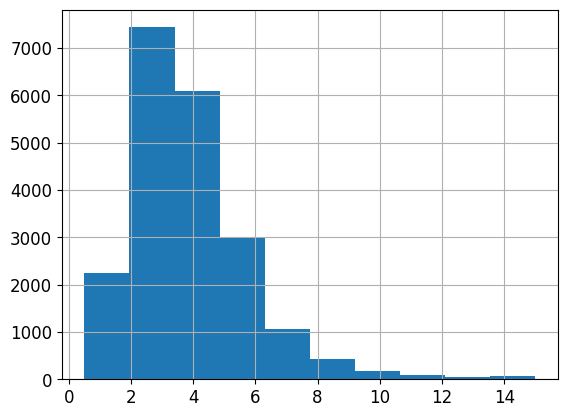

In [16]:
# Supondo que a renda mediana (median_income) é um atributo muito importante para predizer os preços das residencias
# Voce precisa garantir que o seu conjunto de teste seja representativo para as várias categorias de renda
# Como a atributo é numérico, voce precisa criar um atributo categórico a partir da renda mediana


housing["median_income"].hist()

In [17]:
# É importante ter um número suficiente de instancias em cada estrato para evitar um viés
# Voce nao deve ter muitos estratos e cada estrato deve ser o grande o suficiente
# O código abaixo usa a função cut para criar 5 categorias (nomeadas de 1 a 5), variando de acordo com os bins
# Categoria 1: [0, 1.5] Categoria 2: [1.5, 3.0] ...

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [18]:
#Analise a distribuição por categoria

housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

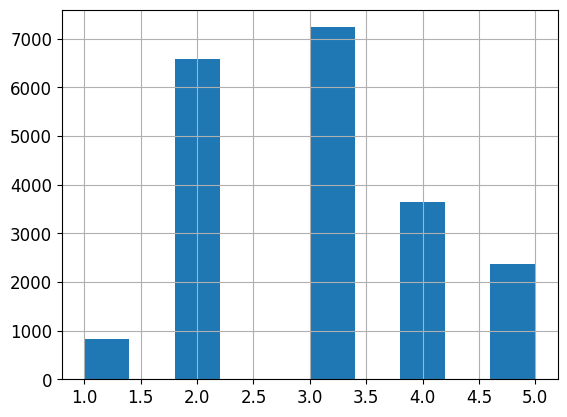

In [19]:
housing["income_cat"].hist()

In [22]:
# Agora voce pode dividir seu conjunto de dados pela amostra estratificada
# A função StratifiedShuffleSplit do SciKit Learn pode ser usada para isso
# StratifiedShuffleSplit: Fornece índices de treinamento/teste para dividir dados em conjuntos de treinamento/teste. 
# Este objeto de validação cruzada é uma mesclagem de StratifiedKFold e ShuffleSplit, que retorna fragmentos aleatórios estratificados. 
# Os fragmentos são criados preservando a porcentagem de amostras para cada classe.

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [23]:
# Podemos avaliar se as proporções no test set e compará-las com o dataset real

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [24]:
# Aqui são apresentadas as proporções dataset original

housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [25]:
# Com esta função podemos analisar as proporções no dado original, dado estratificado e dado selecionado aleatoriamente


def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [26]:
# Na tabela abaixo é apresentada a taxa de erro em relacao ao conjunto original para com o aleatorio e estratificado. 
# Veja que o erro do estratificado é bem menor

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [27]:
# Após o uso do atributo estratificado é necessário eliminá-lo do dataset

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

---

# ***Final da primeira parte, continuamos na próxima aula***

---

# Descobrir e visualizar os dados para obter insights

In [28]:
# Nesta parte exploraremos recursos visuais para entender os dados

housing = strat_train_set.copy()

Saving figure bad_visualization_plot


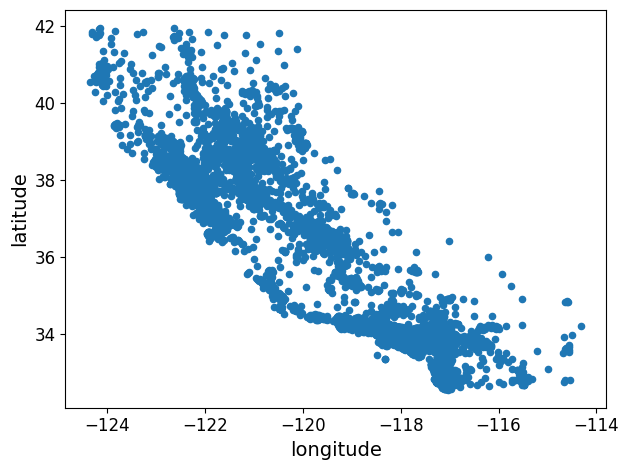

In [29]:
# Com este plot é difícil identificar qualquer padrão

housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


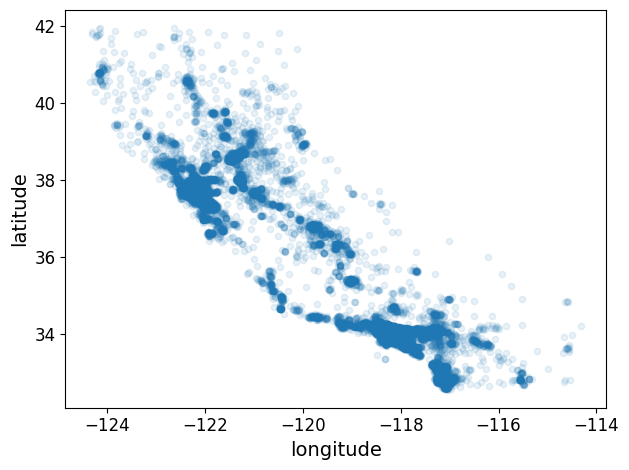

In [30]:
# Usando o parametro alpha, é possível visualizar melhor as áreas de mais densidade de residencias

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611 ). Thanks to Wilmer Arellano for pointing it out.

Saving figure housing_prices_scatterplot


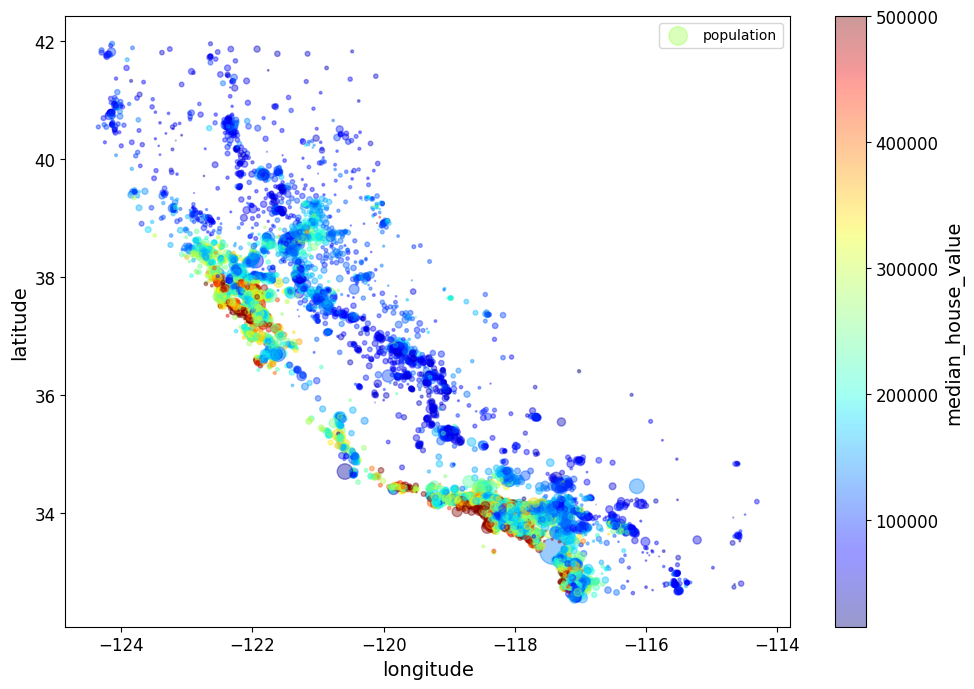

In [31]:
# Com este gráfico mais detalhado podemos analisar a polulação por distrito (circulo)
# O preço representado pela cor
# Podemos perceber que os preços são bastante relacionados com a localização e densidade populacional
# A proximidade com o oceano é algo relevante a ser levando em consideração

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

In [32]:

images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x2b79cbcfb08>)

Saving figure california_housing_prices_plot


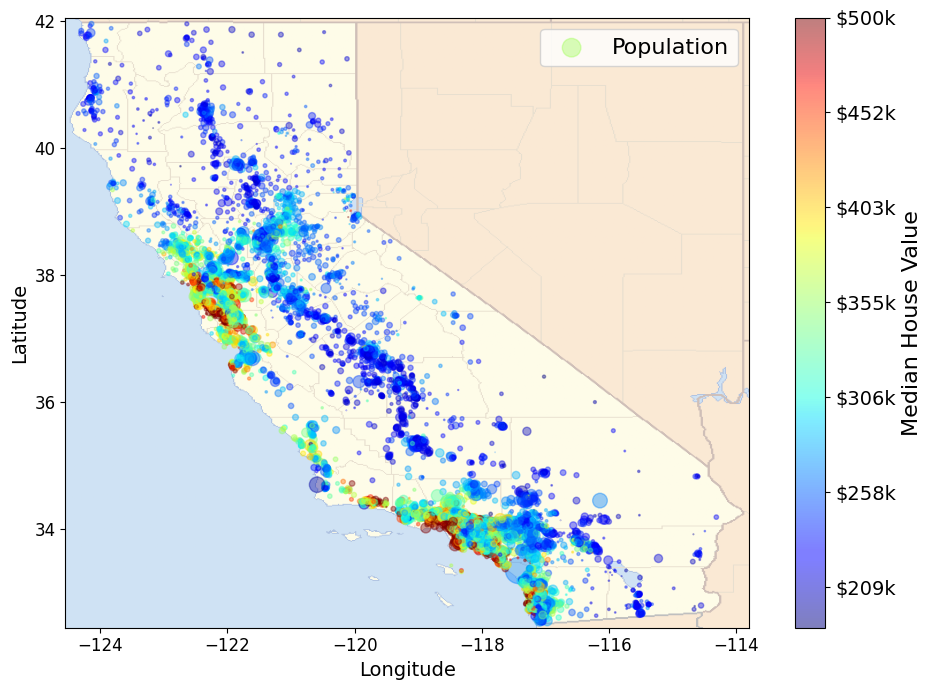

In [33]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [34]:
# Como o dataset não é grande podemos realizar uma análise de correlação 
# entre cada par de atributos 


corr_matrix = housing.corr()

In [35]:
# Neste exemplo listamos a mediana do valor da residencia com os outros atributos 
# Correlação próxima de 1 significa que existe uma forte correlação positiva
# Correlação próxima de -1 significa que existe uma forte correlação negativa

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687323
total_rooms           0.128795
housing_median_age    0.100961
households            0.060945
total_bedrooms        0.045510
population           -0.030417
longitude            -0.048705
latitude             -0.141223
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


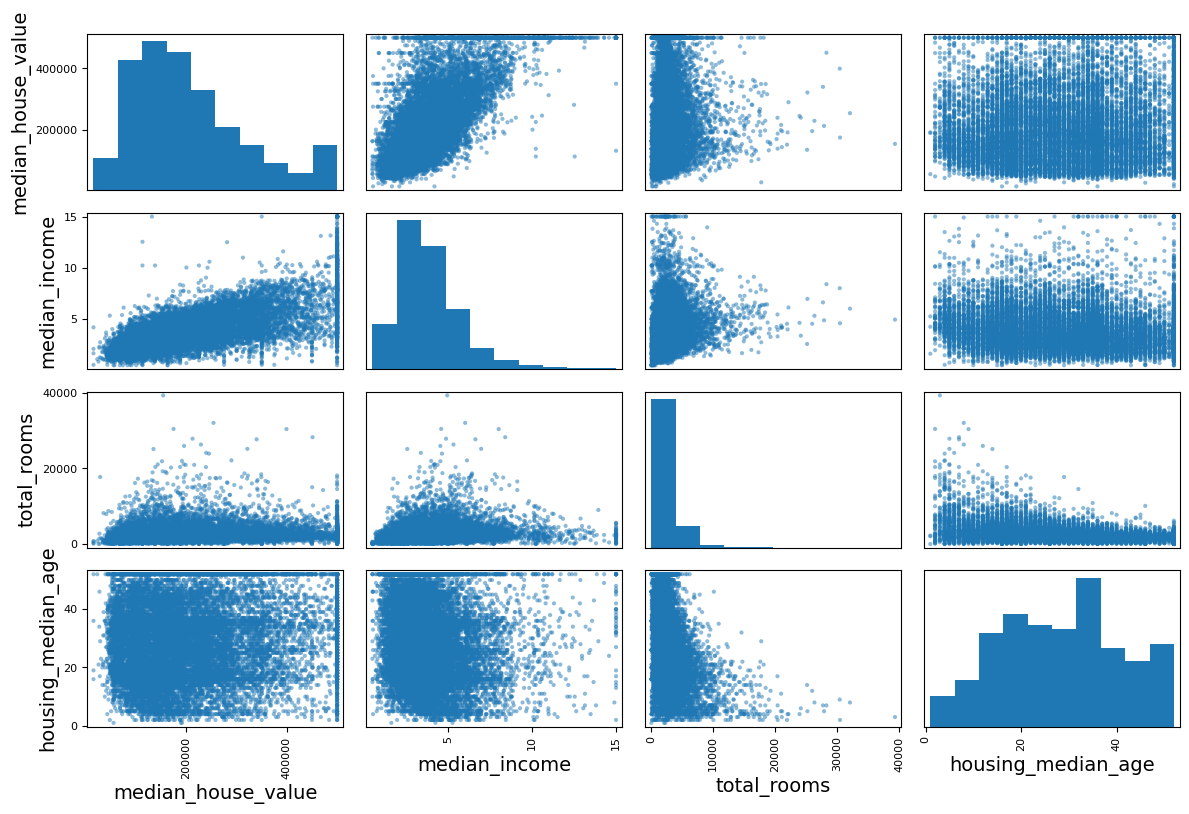

In [36]:
# Avaliando as correlações abaixo, observamos que existe uma alta correlação positiva entre median_income e median_house_value


# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure income_vs_house_value_scatterplot


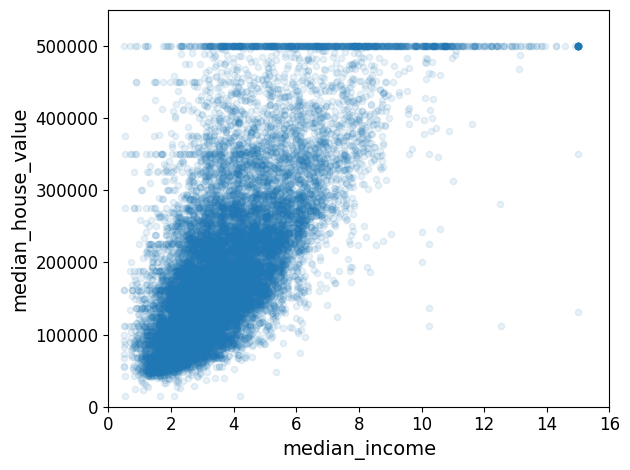

In [37]:
# Plotando a correlação entre median_income e median_house_value
# Verificamos que esta correlação é bem forte
# Perceba as linhas horizontais, talvez seja interessante removelas do dataset para ajudar a melhorar a acuracia do modelo

housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

In [38]:
# Nesta fase é interessante testar novas combinações de atributos para ajudar no treinamento do modelo
# Os atributos abaixo foram criados, pois podem dar mais significado aos dados
# Por exemplo: o total de quartos (total_rooms) por distrito pode nao ser útil, mas a quantidade média de quartos por residencia sim

housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [40]:
# Note que os novos atributos criados tem boa correlação com o valor mediano da residencia
# Veja que bedrooms_per_room é mais correlacionado do que o total_rooms

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687323
rooms_per_household         0.144264
total_rooms                 0.128795
housing_median_age          0.100961
households                  0.060945
total_bedrooms              0.045510
population_per_household   -0.019786
population                 -0.030417
longitude                  -0.048705
latitude                   -0.141223
bedrooms_per_room          -0.254286
Name: median_house_value, dtype: float64

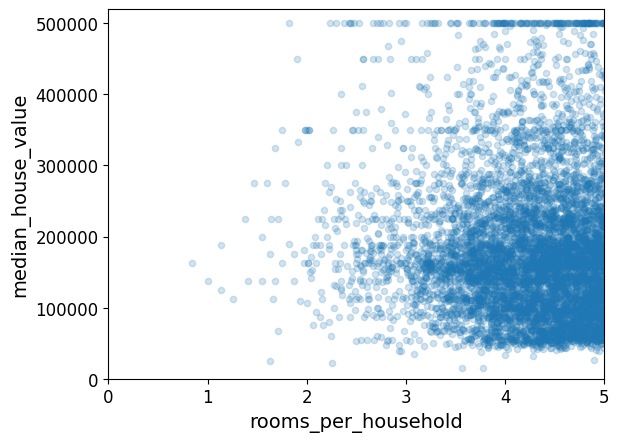

In [41]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [42]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16349.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16349.000000,16512.000000
mean,-119.564694,35.625174,28.589995,2647.417151,541.116827,1429.616158,502.034218,3.870939,207068.985344,5.435030,0.213053,3.055805
std,2.002616,2.136201,12.641759,2177.708140,423.727687,1123.283933,382.478980,1.893218,115672.673289,2.606018,0.057716,10.604075
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.100000,0.692308
25%,-121.790000,33.930000,18.000000,1458.000000,297.000000,790.000000,281.000000,2.565800,119600.000000,4.439341,0.175578,2.425358
50%,-118.490000,34.250000,29.000000,2134.000000,437.000000,1171.000000,411.000000,3.540900,179700.000000,5.223172,0.203364,2.816617
75%,-118.000000,37.710000,37.000000,3165.250000,649.000000,1730.000000,608.000000,4.738600,265000.000000,6.043089,0.239833,3.283921
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Preparar os dados para os algoritmos de aprendizagem de maquina

In [43]:
# Nesta etapa, iremos preparar os dados para os algoritmos de Machine Learning
# Começamos separando os rótulos do conjunto de treinamento

housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [44]:
# Precisamos limpar os dados agora, inciando pelos valores faltantes (missing values)
# Podemos usar 3 estratégias: (1) eliminar a amostra, (2) eliminar o atributo com dado faltante ou (3) atribuir valores (zero, média, mediana)

sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14015,-117.17,32.75,52.0,1052.0,NaN,381.0,201.0,3.0726,NEAR OCEAN
16105,-122.50,37.75,44.0,1819.0,NaN,1137.0,354.0,3.4919,NEAR OCEAN
2323,-119.73,36.83,8.0,3602.0,NaN,1959.0,580.0,5.3478,INLAND
15607,-116.66,32.79,13.0,843.0,NaN,918.0,152.0,6.2152,<1H OCEAN
5222,-118.25,33.95,28.0,2136.0,NaN,1799.0,476.0,1.5427,<1H OCEAN


In [45]:
# Opcao 1 - eliminar a amostra

sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [46]:
# Opcao 2 - eliminar o atributo
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14015,-117.17,32.75,52.0,1052.0,381.0,201.0,3.0726,NEAR OCEAN
16105,-122.50,37.75,44.0,1819.0,1137.0,354.0,3.4919,NEAR OCEAN
2323,-119.73,36.83,8.0,3602.0,1959.0,580.0,5.3478,INLAND
15607,-116.66,32.79,13.0,843.0,918.0,152.0,6.2152,<1H OCEAN
5222,-118.25,33.95,28.0,2136.0,1799.0,476.0,1.5427,<1H OCEAN


In [47]:
# Opcao 3 - preencher com a mediana
# Se lembre de substituir os missing values no conjunto de teste

median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3

In [48]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14015,-117.17,32.75,52.0,1052.0,437.0,381.0,201.0,3.0726,NEAR OCEAN
16105,-122.50,37.75,44.0,1819.0,437.0,1137.0,354.0,3.4919,NEAR OCEAN
2323,-119.73,36.83,8.0,3602.0,437.0,1959.0,580.0,5.3478,INLAND
15607,-116.66,32.79,13.0,843.0,437.0,918.0,152.0,6.2152,<1H OCEAN
5222,-118.25,33.95,28.0,2136.0,437.0,1799.0,476.0,1.5427,<1H OCEAN


In [49]:
# No SciKit Learn existe uma função para tratar dados faltantes: SimplerImpute

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [50]:
# Remover o atributo texto porque a mediana só pode ser calculada em atributos numéricos
housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [51]:
# Calcula a mediana de cada atributo e armazena na variavel statistics_
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [52]:
imputer.statistics_

array([-118.49  ,   34.25  ,   29.    , 2134.    ,  437.    , 1171.    ,
        411.    ,    3.5409])

In [53]:
# Vericando se calculando manualmente daria o mesmo resultado
housing_num.median().values

array([-118.49  ,   34.25  ,   29.    , 2134.    ,  437.    , 1171.    ,
        411.    ,    3.5409])

Transform the training set:

In [54]:
# Com o imputer computado é só usá-lo aplicando a função transformer
# Retorna um NumPy array

X = imputer.transform(housing_num)

In [55]:
# Colocando o NumPy array em um pandas DataFrame

housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [56]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14015,-117.17,32.75,52.0,1052.0,437.0,381.0,201.0,3.0726
16105,-122.50,37.75,44.0,1819.0,437.0,1137.0,354.0,3.4919
2323,-119.73,36.83,8.0,3602.0,437.0,1959.0,580.0,5.3478
15607,-116.66,32.79,13.0,843.0,437.0,918.0,152.0,6.2152
5222,-118.25,33.95,28.0,2136.0,437.0,1799.0,476.0,1.5427


In [57]:
imputer.strategy

'median'

In [58]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [59]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
9763,-121.74,36.47,28.0,1973.0,343.0,970.0,349.0,4.2500
12677,-121.39,38.56,19.0,8507.0,1470.0,3517.0,1453.0,4.3644
16282,-121.29,37.93,37.0,2488.0,578.0,1854.0,514.0,2.5510
5050,-118.33,34.02,11.0,1249.0,313.0,625.0,336.0,0.8702
823,-122.05,37.61,16.0,1642.0,346.0,705.0,351.0,2.8971


Now let's preprocess the categorical input feature, `ocean_proximity`:

In [62]:
housing.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
ocean_proximity        object
dtype: object

In [64]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     7315
INLAND        5248
NEAR OCEAN    2127
NEAR BAY      1818
ISLAND           4
Name: ocean_proximity, dtype: int64

In [60]:
# Atributos não numericos devem ser tratados 
# Neste conjunto de dados só temos um atributo do tipo texto: ocean_proximity

housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
9763,<1H OCEAN
12677,INLAND
16282,INLAND
5050,<1H OCEAN
823,NEAR BAY
15715,NEAR BAY
8701,<1H OCEAN
17054,NEAR OCEAN
2808,INLAND
20033,INLAND


In [63]:
# Existem um numero limitado de categorias
# Os algoritmos de ML preferem atributos numericos, então vamos converter categorias em números
# Para isso usaremos a classe OrdinalEncoder do SciKit Learn

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [1.],
       [1.],
       [0.],
       [3.],
       [3.],
       [0.],
       [4.],
       [1.],
       [1.]])

In [65]:
# Voce pode recuperar a lista de categrias usando a variavel de instancia categories_

ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [66]:
# No entanto, com a representação anterior,os algoritmos assumirão que numeros próximos são mais similares
# Neste caso, não faz sentido releacionar a proximadade dos valores com a proximidade das categorias
# Para consertar este problema, vamos usar um atributo binário por categoria
# Exemplo:  <1H OCEAN   INLAND
#              1        0 => <1H OCEAN
#              0        1 => INLAND
# 

 # id,  oceanproximity
 #  1,   INLAND
 #  2,   NEAR OCEAN

 # id, INLAND, NEAR OCEAN
 #  1,   1,      0
 #  2,   0,      1 

# Esta estratégia de codificação é chamada ONEHOT ENCODING - um único atributo recebe o valor 1
# O SciKit possui uma classe chamada OneHotEncoder para realizar este trabalho

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [67]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [68]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [69]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Let's create a custom transformer to add extra attributes:

In [70]:
# O SciKit prove diversas funções tranformers úteis que podem ser usadas em diversas tarefas: limpeza, junção, etc
# Com os transformers é possível criar pipelines de tarefas customizadas
# O exemplo abaixo implementa um transformer para adicionar os atributos combinados no dataset

from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6


# Esta classe recebe um parametro que permite incluir ou nao bedrooms_per_room
# Isto permite testar o treinamento do algoritmo com e sem este atributo
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Note that I hard coded the indices (3, 4, 5, 6) for concision and clarity in the book, but it would be much cleaner to get them dynamically, like this:

In [71]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

Also, `housing_extra_attribs` is a NumPy array, we've lost the column names (unfortunately, that's a problem with Scikit-Learn). To recover a `DataFrame`, you could run this:

In [72]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
9763,-121.74,36.47,28.0,1973.0,343.0,970.0,349.0,4.25,<1H OCEAN,5.653295,2.77937
12677,-121.39,38.56,19.0,8507.0,1470.0,3517.0,1453.0,4.3644,INLAND,5.854783,2.420509
16282,-121.29,37.93,37.0,2488.0,578.0,1854.0,514.0,2.551,INLAND,4.840467,3.607004
5050,-118.33,34.02,11.0,1249.0,313.0,625.0,336.0,0.8702,<1H OCEAN,3.717262,1.860119
823,-122.05,37.61,16.0,1642.0,346.0,705.0,351.0,2.8971,NEAR BAY,4.678063,2.008547


Now let's build a pipeline for preprocessing the numerical attributes:

In [73]:
# Uma das transformações mais importantes é realizar o escalonamento de atributos (feature scaling)
# Os algoritmos de ML não performam bem quando atributos tem escalas diferentes
# Este é o caso dos atributos number_rooms (6-39320) e median_incomes (0-15)
# Existem duas formas mais comuns de colocar atributos na mesma escala:
#  min-max (normalization - 0-1) e standardization (zero mean - unit variation - menos afetada por outliers)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# A classe Pipeline permite encadear a execução de transformers
# No exemplo abaixo, usamos 3 transformadores SimpleImputer, CombinedAttributesAdder e StandardScaler
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [74]:
housing_num_tr
#housing_num_tr.shape

array([[-1.08626549,  0.39549265, -0.04667175, ...,  0.08375695,
        -0.02606959, -0.606276  ],
       [-0.91148877,  1.37389468, -0.75861953, ...,  0.16107575,
        -0.05991235, -0.62213483],
       [-0.86155257,  1.07896966,  0.66527603, ..., -0.22815679,
         0.05198148,  0.27843984],
       ...,
       [ 0.99108065, -0.92464787, -1.94519917, ..., -0.09734782,
        -0.08466568, -0.04409146],
       [-0.39215224,  1.10237641, -1.94519917, ...,  0.20299752,
        -0.05886127, -0.48980679],
       [ 0.28698015, -0.15222522,  0.3488548 , ...,  0.04435547,
         0.05201953, -0.31554444]])

In [75]:
# O SciKit learn possui um transformer que é útil para fazer transformações sobre colunas
# No nosso caso é importante para aplicarmos transformações em colunas numericas e categoricas

from sklearn.compose import ColumnTransformer

#selecionando os tipos de colunas
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# num_pipeline foi definido anteriormente e vai ser aplicado somente às colunas numéricas
# OneHotEncoder vai ser aplicado somente à coluna ocean_proximity)
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [76]:
housing_prepared

array([[-1.08626549,  0.39549265, -0.04667175, ...,  0.        ,
         0.        ,  0.        ],
       [-0.91148877,  1.37389468, -0.75861953, ...,  0.        ,
         0.        ,  0.        ],
       [-0.86155257,  1.07896966,  0.66527603, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.99108065, -0.92464787, -1.94519917, ...,  0.        ,
         0.        ,  0.        ],
       [-0.39215224,  1.10237641, -1.94519917, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.28698015, -0.15222522,  0.3488548 , ...,  0.        ,
         0.        ,  0.        ]])

In [77]:
# PRONTO ! Aqui temos nosso dataset preparado para o treinamento
# Pule para a próxima seção
housing_prepared.shape

(16512, 16)

For reference, here is the old solution based on a `DataFrameSelector` transformer (to just select a subset of the Pandas `DataFrame` columns), and a `FeatureUnion`:

In [78]:
# PULAR - VERSAO ANTIGA baseada no DataFrameSelector#

from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features:

In [79]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [80]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [81]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-1.08626549,  0.39549265, -0.04667175, ...,  0.        ,
         0.        ,  0.        ],
       [-0.91148877,  1.37389468, -0.75861953, ...,  0.        ,
         0.        ,  0.        ],
       [-0.86155257,  1.07896966,  0.66527603, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.99108065, -0.92464787, -1.94519917, ...,  0.        ,
         0.        ,  0.        ],
       [-0.39215224,  1.10237641, -1.94519917, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.28698015, -0.15222522,  0.3488548 , ...,  0.        ,
         0.        ,  0.        ]])

The result is the same as with the `ColumnTransformer`:

In [82]:
np.allclose(housing_prepared, old_housing_prepared)

True

# Selecionar e Treinar um modelo 

In [84]:
# Nesta etapa iremos fazer a selecao do algoritmo de ML e usá-lo para treinar o modelo
# Esta atividade é bem simples, pois podemos usar os algoritmos implementados pelo Scikit Learn
# Neste caso, usamos um modelo de Regressao Linear

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [85]:
# Aplicando o modelo sobre alguns dados, ou seja, fazendo predições
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [263631.89738966 197915.78138144 110233.5966146  101392.28891583
 187932.46285443]


Compare against the actual values:

In [86]:
# A diferença entre as predições e o valor real são altas, ou seja, o modelo não é adequado

print("Labels:", list(some_labels))

Labels: [279100.0, 137400.0, 59100.0, 170500.0, 163900.0]


In [87]:
some_data_prepared

array([[-1.08626549,  0.39549265, -0.04667175, -0.30970063, -0.46731932,
        -0.40918423, -0.40012356,  0.20022636,  0.08375695, -0.02606959,
        -0.606276  ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.91148877,  1.37389468, -0.75861953,  2.6907923 ,  2.20491912,
         1.8583432 ,  2.48639698,  0.26065442,  0.16107575, -0.05991235,
        -0.62213483,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [-0.86155257,  1.07896966,  0.66527603, -0.07320631,  0.089891  ,
         0.37781783,  0.03128576, -0.69721476, -0.22815679,  0.05198148,
         0.27843984,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.61655911, -0.75143794, -1.39146201, -0.6421703 , -0.53845255,
        -0.7163287 , -0.43411339, -1.58504233, -0.65917418, -0.11276064,
         0.55512632,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.24106773,  0.92916648, -0

In [88]:
# Vamos calcular a performance do modelo usando a métrica RMSE
# A maioria dos valores das residencias variam entre 120.000 e 265.000, então um erro de 68.628 é muito
# Este é um caso de underfitting
# A solução para underfitting é escolher um modelo mais adequado

from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68436.83332719139

**Note**: since Scikit-Learn 0.22, you can get the RMSE directly by calling the `mean_squared_error()` function with `squared=False`.

In [89]:
#Usando outra métrica de performance MAE

from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49372.67919259317

In [90]:
# Tentaremos agora usar outro modelo mais potente: DecisionTreeRegressor
# Este modelo é capaz de encontrar relações não lineares nos dados

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [91]:
# Vamos calcular a performance do modelo usando a métrica RMSE
# Claramente pelo resultado este modelo está causando um sobreajuste sobre os dados (overfitting)
# O RMSE = 0 não é possível
# A solução é aplicar usar CROSS-VALIDATION: uma parte do treinamento para treinar e outra parte para validar
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# Fazer o ajuste fino do modelo

In [92]:
# O Scikit learn provê uma forma para aplicar o método de cross-validation
# O trecho abaixo, divide o dataset em 10 subcojuntos (folds)
# Então ele irá treinar o modelo de Decision Tree 10 vezes
# Para cada execução será selecionado um fold diferente
# O resultado é um array com a avaliação de 10 scores
from sklearn.model_selection import cross_val_score

# A função recebe como parametro uma função utilidade (maior melhor) e não 
# uma função de custo (menor é melhor), por isso a função de scoring passada
# é o valor negativo do MSE
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [93]:
# Os resultados não foram tão bons agora
# O cross-validation permite que voce veja alem da performance media, 
# veja também o quanto isto é preciso (desvio padrão)
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [71738.65256412 69774.82826202 72233.07524329 69803.70873758
 74157.52919185 69766.21942887 72772.6990889  72068.44209091
 71024.42734123 68404.89476747]
Mean: 71174.44767162498
Standard deviation: 1649.4036606067498


In [94]:
# Testando agora o cross-validation com o modelo de regressao linear para comparar
# O modelo RL foi melhor que o modelo da árvore de decisão
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 72971.33454397  69194.8606245   73469.05149657  64336.35013398
 335122.3740396   67027.58199012  66640.24163529  67895.95471823
  69345.90118474  66448.45419965]
Mean: 95245.21045666441
Standard deviation: 80004.90397927516


**Note**: we specify `n_estimators=100` to be future-proof since the default value is going to change to 100 in Scikit-Learn 0.22 (for simplicity, this is not shown in the book).

In [95]:
# Vamos testar outro modelo, denominado RandomForestRegressor
# Este modelo treinará várias árvores de decisão sobre um subconjunto aleatório de features
# Este tipo de modelo implementa um método chamado Ensemble Learning - criar um modelo sobre varios outros modelos
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [96]:
# Calculando o RMSE
# Podemos ver que o modelo melhorou muito !
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18482.355329973416

In [97]:
# Porém perceba que o escore do training set é ainda muito menor do que o escore dos validation sets
# Isso significa que ele deve estar ainda sofrendo overfitting
# Para resolver este problema podemos simplificar o modelo, restringi-lo (regularizando) ou treinando com mais dados
# No entanto, antes de se aprofundar nisso, vale a pena testar com outros modelos

from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51663.14173255 52425.61461447 50536.6667562  46783.39815734
 52195.70741199 48605.9094003  48131.59690413 50029.63917818
 51529.45972102 49649.08785058]
Mean: 50155.02217267697
Standard deviation: 1782.208775237402


In [98]:
# Testando regressão linear com o Cross Validation
# O resultado ainda não é satisfatório
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count        10.000000
mean      95245.210457
std       84332.573519
min       64336.350134
25%       66737.076724
50%       68545.407671
75%       72064.976204
max      335122.374040
dtype: float64

In [99]:
# Testando com o modelo SVM - Support Vector Machine
# O resultado ainda não é satisfatório
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111097.65929581223

In [100]:
# Uma solução para o problema que enfrentamos é ajustarmos os hyperparametros manualmente, achando a melhor combinação
# No entanto, isso pode demorar
# O Scikit provê a classe GridSearchCV para fazer isso para voce

from sklearn.model_selection import GridSearchCV

# Voce precisa definir quais hyperparametros voce deseja experimentar e quais valores quer testar
# O grid search vai usar cross-validation para avaliar todas as possibilidades de combinação dos hiperparametros
# Neste exemplo, serão 12 combinações para primeiro dict e 6 para o segundo dict


param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

# No total serão 12 + 6 = 18 combinações executados do modelo RandomForestRegressor
# Como executará 5 cross-validation, então executará no total 18 * 5 = 90 rodadas de treinamento
forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

The best hyperparameter combination found:

In [101]:
# Aqui é apresentada a melhor combinação de parametros
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [102]:
# A variavel best_estimator_ apresenta o melhor modelo com seus parametros
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [103]:
# Podemos visualizar os escores das avaliações (18) realizadas
# Podemos observar que o melhor escore é 49,689 relacionado com melhor estimator (linha 12)
# O resultado melhou o ultimo treinamento realizado 50,182
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64770.37978965491 {'max_features': 2, 'n_estimators': 3}
56045.85779613324 {'max_features': 2, 'n_estimators': 10}
53068.211760407285 {'max_features': 2, 'n_estimators': 30}
59737.980132014265 {'max_features': 4, 'n_estimators': 3}
52450.81205674015 {'max_features': 4, 'n_estimators': 10}
50324.83137163025 {'max_features': 4, 'n_estimators': 30}
58672.71168667361 {'max_features': 6, 'n_estimators': 3}
51496.07414698095 {'max_features': 6, 'n_estimators': 10}
49988.60708089141 {'max_features': 6, 'n_estimators': 30}
58837.48976211523 {'max_features': 8, 'n_estimators': 3}
52224.62603993771 {'max_features': 8, 'n_estimators': 10}
49853.4090617268 {'max_features': 8, 'n_estimators': 30}
61780.82101655205 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53981.89121509452 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59283.570688948865 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52403.482898779104 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [104]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.047010,0.002540,0.002799,0.000400,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.483248e+09,-3.901009e+09,...,-4.195202e+09,1.892012e+08,18,-1.086919e+09,-1.111381e+09,-1.155550e+09,-1.180084e+09,-1.119317e+09,-1.130650e+09,3.309346e+07
1,0.178352,0.021899,0.008813,0.000991,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.301926e+09,-2.999231e+09,...,-3.141138e+09,1.265270e+08,11,-5.817611e+08,-5.924095e+08,-6.046419e+08,-5.922341e+08,-5.765112e+08,-5.895115e+08,9.734642e+06
2,0.476602,0.015429,0.021397,0.001499,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.955087e+09,-2.698535e+09,...,-2.816235e+09,1.015790e+08,9,-4.422197e+08,-4.468978e+08,-4.376202e+08,-4.356993e+08,-4.262051e+08,-4.377284e+08,6.944990e+06
3,0.080197,0.003188,0.002993,0.000016,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.708151e+09,-3.259674e+09,...,-3.568626e+09,1.904396e+08,16,-8.680313e+08,-9.034396e+08,-1.031221e+09,-1.027758e+09,-9.066755e+08,-9.474251e+08,6.837214e+07
4,0.251601,0.008675,0.007604,0.000476,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.936828e+09,-2.581069e+09,...,-2.751088e+09,1.239786e+08,8,-4.846643e+08,-4.957415e+08,-5.279917e+08,-5.193457e+08,-4.989618e+08,-5.053410e+08,1.593459e+07
5,0.736809,0.024301,0.021597,0.000490,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.713537e+09,-2.385167e+09,...,-2.532589e+09,1.199513e+08,3,-3.807303e+08,-3.890828e+08,-3.879465e+08,-3.934455e+08,-3.835200e+08,-3.869450e+08,4.431320e+06
6,0.098001,0.003570,0.002400,0.000488,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.576182e+09,-3.379275e+09,...,-3.442487e+09,1.305691e+08,13,-8.605396e+08,-9.143352e+08,-8.928085e+08,-8.981079e+08,-9.268273e+08,-8.985237e+08,2.247989e+07
7,0.344405,0.009018,0.007997,0.000632,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.758197e+09,-2.555103e+09,...,-2.651846e+09,1.120338e+08,5,-4.640808e+08,-4.908162e+08,-4.811026e+08,-4.904205e+08,-4.876776e+08,-4.828195e+08,9.994102e+06
8,1.047397,0.041876,0.023603,0.001370,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.705076e+09,-2.382383e+09,...,-2.498861e+09,1.282453e+08,2,-3.807391e+08,-3.900072e+08,-3.722154e+08,-3.789833e+08,-3.756585e+08,-3.795207e+08,6.000395e+06
9,0.139024,0.006326,0.003001,0.000632,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.413072e+09,-3.342815e+09,...,-3.461850e+09,1.333845e+08,14,-8.634424e+08,-9.026875e+08,-9.170696e+08,-9.030076e+08,-9.031583e+08,-8.978731e+08,1.806352e+07


In [105]:
# Quando o numero de combinações possíveis é muito grande, então é melhor aleatorizar 
# a seleção das combinações.
# Isso pode ser realizado usando a classe RandomizedSearchCV
# É similar ao GridSearchCV, mas sem testar todas as combinações possíveis

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# É possível definir uma faixa de estimadores e features
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002B79F5DB448>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002B79F5DBE48>},
                   random_state=42, scoring='neg_mean_squared_error')

In [106]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

48956.28995683522 {'max_features': 7, 'n_estimators': 180}
51488.33643874324 {'max_features': 5, 'n_estimators': 15}
50272.78858874082 {'max_features': 3, 'n_estimators': 72}
50752.190996513214 {'max_features': 5, 'n_estimators': 21}
49057.97065254648 {'max_features': 7, 'n_estimators': 122}
50261.23032225846 {'max_features': 3, 'n_estimators': 75}
50077.73395990299 {'max_features': 3, 'n_estimators': 88}
49285.86193572603 {'max_features': 5, 'n_estimators': 100}
49921.18665092002 {'max_features': 3, 'n_estimators': 150}
65370.81357238013 {'max_features': 5, 'n_estimators': 2}


In [107]:
# Nós podemos ganhar bons insights do problema inspencionado os melhores modelos.
# Neste exemplo, podemos coletar informações sobre a importancia relativa de cada atriuto

feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.29324916e-02, 6.23162388e-02, 4.20955909e-02, 1.46372478e-02,
       1.47909681e-02, 1.46645965e-02, 1.36931014e-02, 3.66427819e-01,
       5.39033664e-02, 1.09764301e-01, 5.52714915e-02, 5.65355066e-03,
       1.68393233e-01, 1.13269778e-04, 1.90539439e-03, 3.43733870e-03])

In [108]:
# Para facilitar a leitura, vamos imprimir com os nomes dos atributos
# Com esta informação podemos decidir eliminar algumas features desenecessárias
# Por exemplo, somente uma categoria do ocean_proximity parece ser boa (INLAND)

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3664278192356496, 'median_income'),
 (0.16839323295348882, 'INLAND'),
 (0.10976430135812541, 'pop_per_hhold'),
 (0.07293249161783781, 'longitude'),
 (0.062316238756590696, 'latitude'),
 (0.0552714915093689, 'bedrooms_per_room'),
 (0.05390336643785543, 'rooms_per_hhold'),
 (0.04209559085384424, 'housing_median_age'),
 (0.014790968092422984, 'total_bedrooms'),
 (0.014664596451055124, 'population'),
 (0.014637247847532025, 'total_rooms'),
 (0.01369310136298973, 'households'),
 (0.005653550656795247, '<1H OCEAN'),
 (0.0034373386958796758, 'NEAR OCEAN'),
 (0.0019053943921116018, 'NEAR BAY'),
 (0.00011326977845276624, 'ISLAND')]

In [109]:
# Finalmente, depois de treinar seu modelo e fazê-lo obter os melhores resultados,
# é hora de aplicar seu modelo no seu conjunto de teste.
# Nao há nada especial neste processo, é só reproduzir o processo usando os dados de teste

# seleciona o modelo treinado
final_model = grid_search.best_estimator_

# Separar rotulos das features
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Realizar a transformação dos dados
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

#Calcular a performance
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [110]:
final_rmse

48539.05071322199

In [119]:
from sklearn.metrics import mean_absolute_error

# Realizar a transformação dos dados
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

# Calcular a performance
final_mae = mean_absolute_error(y_test, final_predictions)
final_mae

32109.959641472866

In [120]:
from sklearn.metrics import r2_score

# Realizar a transformação dos dados
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

# Calcular a performance
final_r2_score = r2_score(y_test, final_predictions)
final_r2_score

0.8195874639570941

In [111]:
# Neste momento, voce pode não se sentir confiante para usá-lo no mundo real, pois
# não sabe se o resultado é confiável. Para isso deve computar o intervalo de confiança a 95%
# Este teste vai te permitir avaliar se o intervalo é razoável para sua aplicação
# Neste caso, ele variou entre 45.685 até 49.691
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([46293.01099348, 50685.65893267])

We could compute the interval manually like this:

In [112]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(46293.01099348154, 50685.6589326692)

Alternatively, we could use a z-scores rather than t-scores:

In [113]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(46293.68568250277, 50685.04270700686)

***Neste exemplo, o resultado final não parece tão bom quanto a de um especialista, que gira em torno de 20%, mas pode ser interessante usar este modelo como um parametro inicial e pode liberar os especialistas desta atividade.***

---

# ***Final da segunda parte, assistam os videos e leiam o capitulo 2 do livro do Aurelien Geron***

---

# Material Extra

## A full pipeline with both preparation and prediction

In [114]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([263631.89738966, 197915.78138144, 110233.5966146 , 101392.28891583,
       187932.46285443])

In [123]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", RandomForestRegressor(n_estimators=100, random_state=42))
    ])
full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([267993., 152788.,  67533., 193956., 172340.])

## Model persistence using joblib

In [115]:
my_model = full_pipeline_with_predictor

In [116]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## Example SciPy distributions for `RandomizedSearchCV`

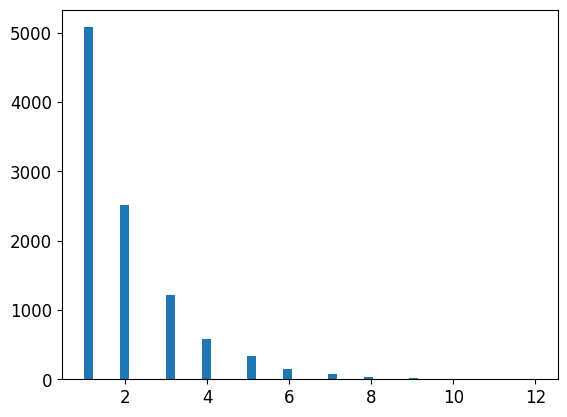

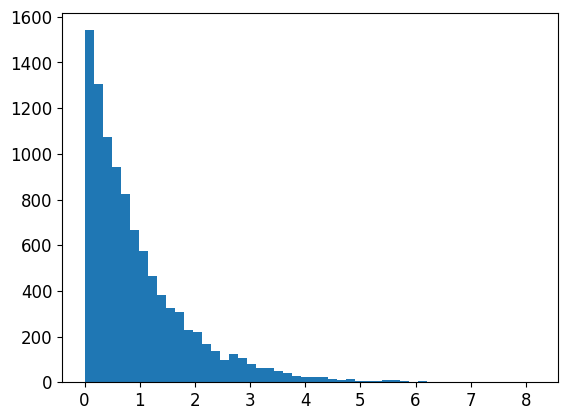

In [117]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()